In [1]:
%config Completer.use_jedi = False

In [2]:
import autorootcwd
from src.utils import convert_csi_to_amplitude, plot_csi_amplitude, plot_csi_amplitude_from_file
from scipy.signal import medfilt
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

#파일 경로 및 파라미터
#2분동안 수집한 no-activity 신호 (1개 device, 52 subcarrier)
NO_ACTIVITY_CSI_PATH = r"data\raw\raw_noActivity_csi\merged_csi_data_noactivity.csv" 
ACTIVITY_CSI_PATH = r"data\raw\raw_activity_csi\merged_csi_data_dooropen.csv" 
# 10분 동안 수집한 calibration data -> 정지 상태 기준으로 정규화 위함
CALIB_PATH = r"data\calibration\L0382_ESP_8_bg_params.csv" 

FRAME_NUM = 500 # 6초
SUBCARRIER_NUM = 52 # subcarrier 개수 (52로 고정)
WIN_SIZE = 64
TICK_SPACING = 10 # plot 시 tick 간격

# activity csi 진폭 & time stamp
amp_activity, ts_activity = convert_csi_to_amplitude(ACTIVITY_CSI_PATH, SUBCARRIER_NUM)

#### 1st Processing :노이즈 한 채널을 제거(21~31 채널을 메뉴얼하게 삭제)

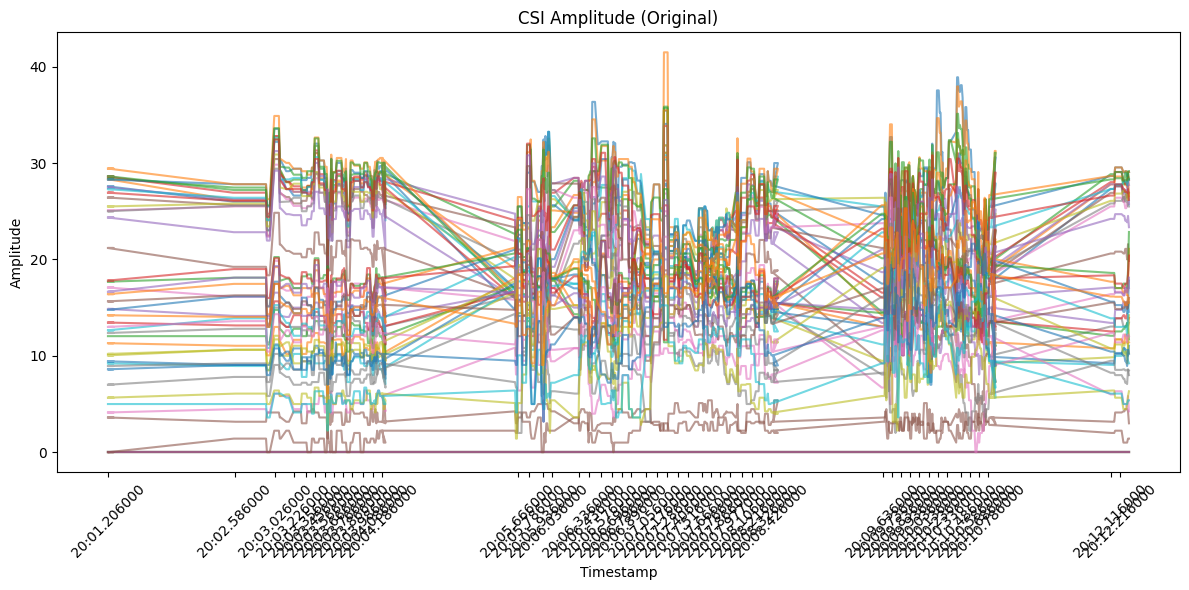

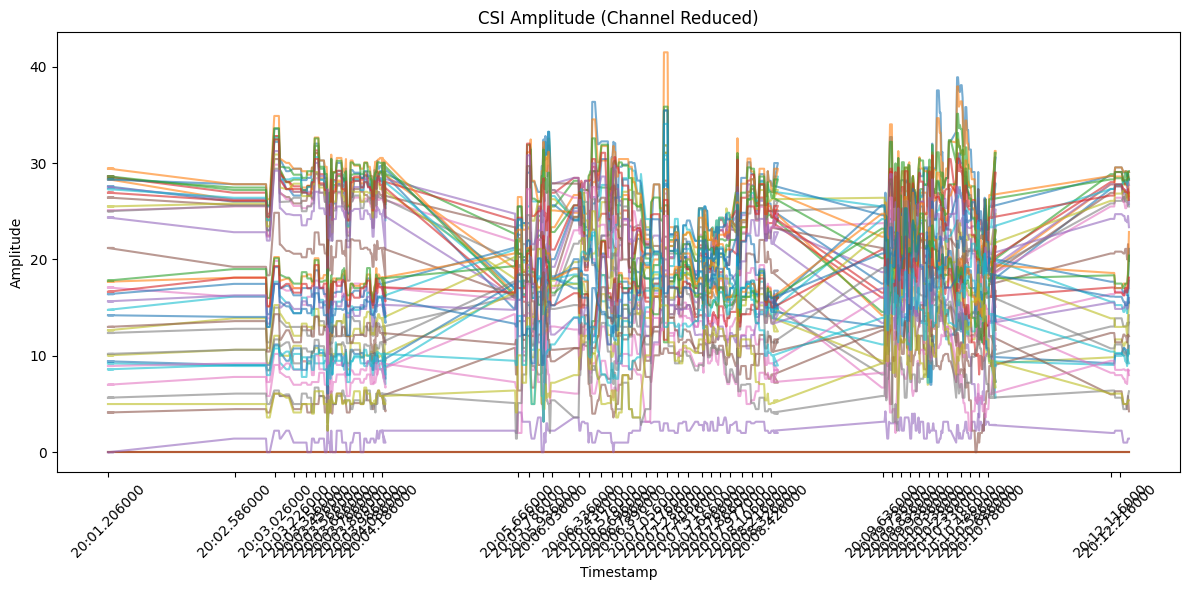

In [3]:
indices_to_remove = list(range(21,32))
amp_reduced = np.delete(amp_activity, indices_to_remove, axis=1) # automatic 하게 노이즈 채널 제거 방법?

plot_csi_amplitude(amp_activity, ts_activity, "CSI Amplitude (Original)")
plot_csi_amplitude(amp_reduced, ts_activity, "CSI Amplitude (Channel Reduced)")

#### 2nd Processing : Z-score normalization

In [4]:
def read_calibration(CALIB_PATH): # src/atif.py
    '''
    Read calibration data
    param CALIB_PATH : path to the Calibration data 

    Example :
        CALIB_PATH = r"data\CSI_Calibration\L0382_ESP_8_bg_params.csv"
        mu_bg, sigma_bg = read_calibration(CALIB_PATH)
    '''
    calib = pd.read_csv(CALIB_PATH, header=None)
    mu_bg    = calib.iloc[0].values.astype(float)
    sigma_bg = calib.iloc[1].values.astype(float) 
    sigma_bg[sigma_bg == 0] = 1  # 0인 σ는 1로 대체 (0으로 나누기 방지)

    return mu_bg, sigma_bg

mu_bg, sigma_bg = read_calibration(CALIB_PATH)

#결과 확인
print(f'Length of amp_reduced: {amp_reduced.shape[1]}')
print(f'mu_bg (length:{len(mu_bg)})', mu_bg)
print(f'sigma_bg (length:{len(sigma_bg)})',sigma_bg)

Length of amp_reduced: 41
mu_bg (length:41) [18.29274345 13.56749181  8.8733715   6.57748039  8.27448634 11.45728306
 16.09709446 20.4515111  23.97356723 26.37220828 27.71965014 28.17616118
 27.81608488 26.74619042 24.9891651  22.73337303 20.16097475 17.33868066
 14.3470272  11.25029442  8.52433585  0.          0.          0.
  3.92742669 15.25522786 14.62853568 14.06798533 14.07394771 14.95548663
 16.81959005 19.22446033 21.6481152  23.69109249 24.96589236 25.20909326
 24.29943241 22.40305862 20.10212114 17.94571995 16.34877842]
sigma_bg (length:41) [7.31089281 7.04122144 6.3095598  4.12653022 1.31319935 3.87945205
 3.82228336 3.13605542 2.49319228 2.22259915 2.51137335 3.07547955
 3.63779542 3.91306119 3.72980707 3.0882062  2.24934375 1.60884109
 1.82236858 2.46051326 2.51224303 1.         1.         1.
 0.91730741 2.93753974 2.78490164 2.58844655 2.35428599 2.17629342
 2.16917198 2.26618073 2.40175454 2.58570814 2.72784752 2.79338813
 2.80006863 2.79352484 2.83774423 2.99300332 3.26

In [5]:
def z_normalization(amp, mu, sigma ) : 
    '''
    Desc :
        Z-score normalizaion & visualization
        param mu_bg : 각 서브캐리어에 대한 평균값
        param sigma_bg : 각 서브캐리어에 대한 표준편차
    
    Example : 
        mu_bg, sigma_bg = read_calibration(_, _) 
        z_normalization(amp_reduced, mu_bg, sigma_bg)
    '''
    mu_bg = mu
    sigma_bg = sigma
    amp_normalized  = (amp - mu_bg) / sigma_bg
    
    return amp_normalized

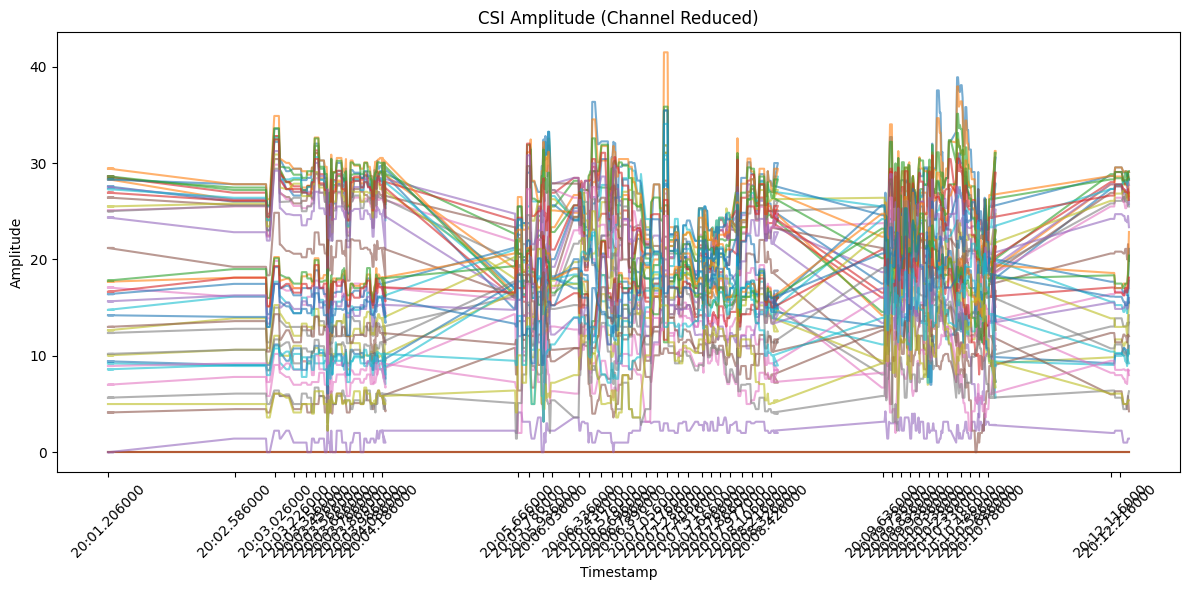

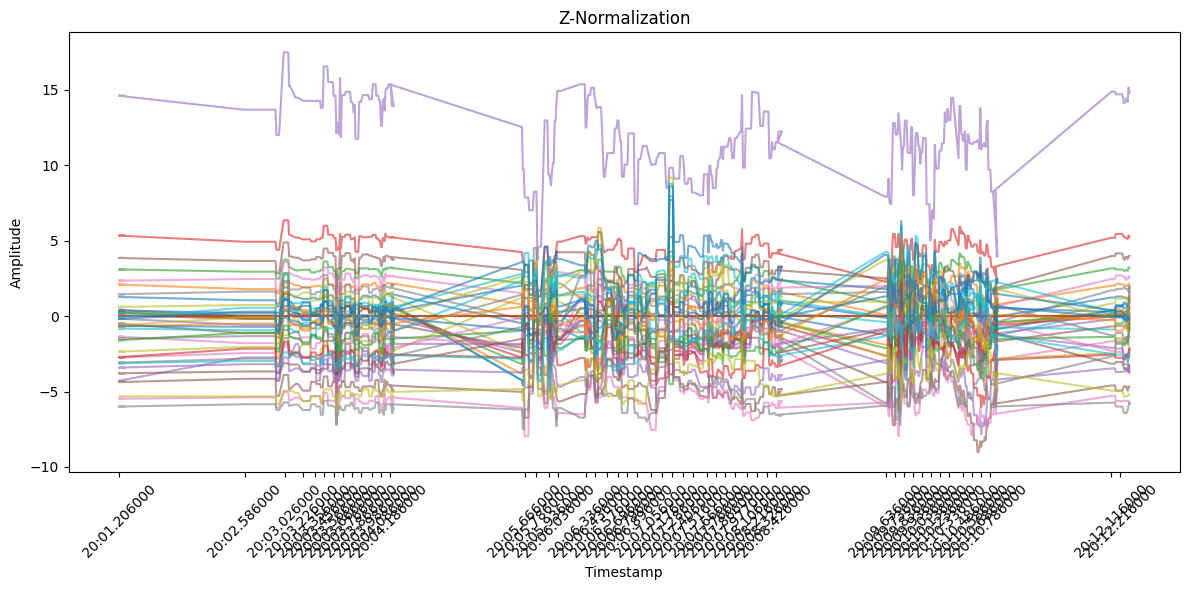

In [6]:
amp_normalized = z_normalization(amp_reduced, mu_bg, sigma_bg)

plot_csi_amplitude(amp_reduced, ts_activity, "CSI Amplitude (Channel Reduced)")
plot_csi_amplitude(amp_normalized, ts_activity, title="Z-Normalization")

#### 3rd Processing : Normalized amp filtering (이상치 제거 )

In [7]:
def filter_normalization(amp_normalized, iqr_multiplier=1.5, gap_threshold=0.2):
    ''' 
    Desc : 
        normalization 이후 서브캐리어 평균 기반(사분위수 사용용) 이상치 제거 (단 1개만 확실히 튈 때만)
    '''
    # 1. 평균 계산 
    means = np.mean(amp_normalized, axis=0)

    # 2. IQR 계산
    q1 = np.percentile(means, 25) # 하위 25% : -2.11
    q3 = np.percentile(means, 75) # 상위 75% : 0.44
    iqr = q3 - q1
    upper = q3 + iqr_multiplier * iqr # 4.27

    # 3. 평균값 내림차순 정렬
    sorted_indices = np.argsort(means)[::-1]
    top1_idx = sorted_indices[0] # 4번
    top2_idx = sorted_indices[1] # 3번
    top1_val = means[top1_idx]  # 4번 평균 :13.42 
    top2_val = means[top2_idx]  # 3번 평균 :4.85 


    # 4. 최대 평균이 upper보다 크고, 다음 값과 차이가 충분히 날 경우만 제거
    if top1_val > upper and (top1_val - top2_val) > gap_threshold:
        invalid_indices = [top1_idx]
    else:
        invalid_indices = []
    
    amp_norm_filtered = np.delete(amp_normalized, invalid_indices, axis=1 )

    print(f"[filter_normalization] Q1 = {q1:.2f}, IQR = {iqr:.2f}, upper = {upper:.2f}")
    print(f"[filter_normalization] Top1: SC {top1_idx}, mean = {top1_val:.2f}")
    print(f"[filter_normalization] Top2: SC {top2_idx}, mean = {top2_val:.2f}")
    print(f"[filter_normalization] Removed: {invalid_indices}")

    return  amp_norm_filtered


[filter_normalization] Q1 = -2.11, IQR = 2.55, upper = 4.27
[filter_normalization] Top1: SC 4, mean = 13.42
[filter_normalization] Top2: SC 3, mean = 4.85
[filter_normalization] Removed: [np.int64(4)]


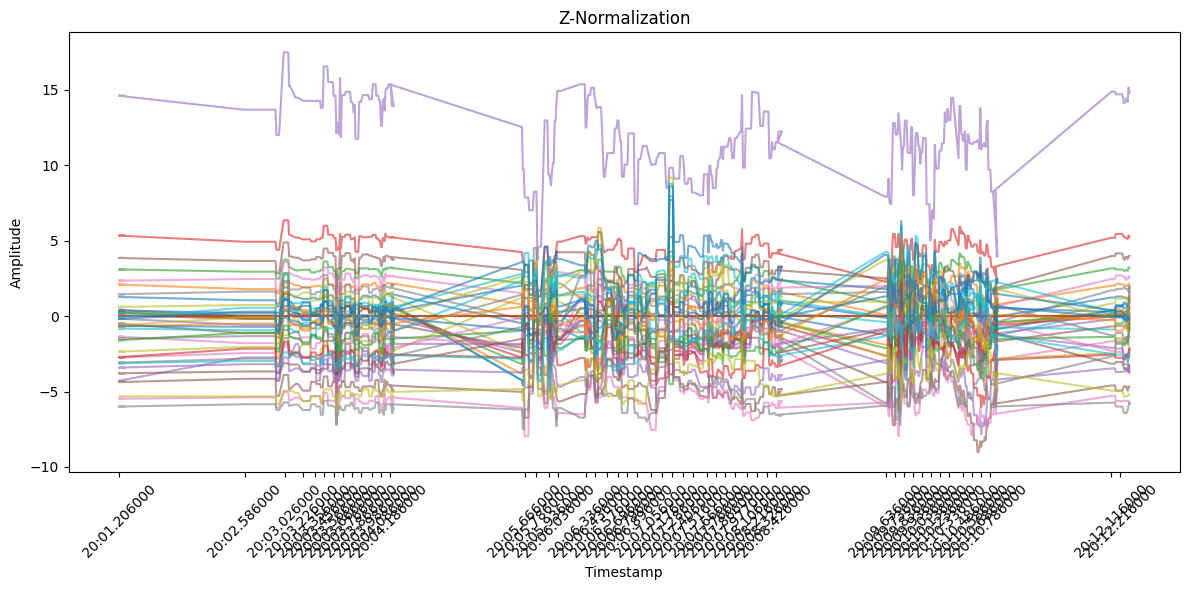

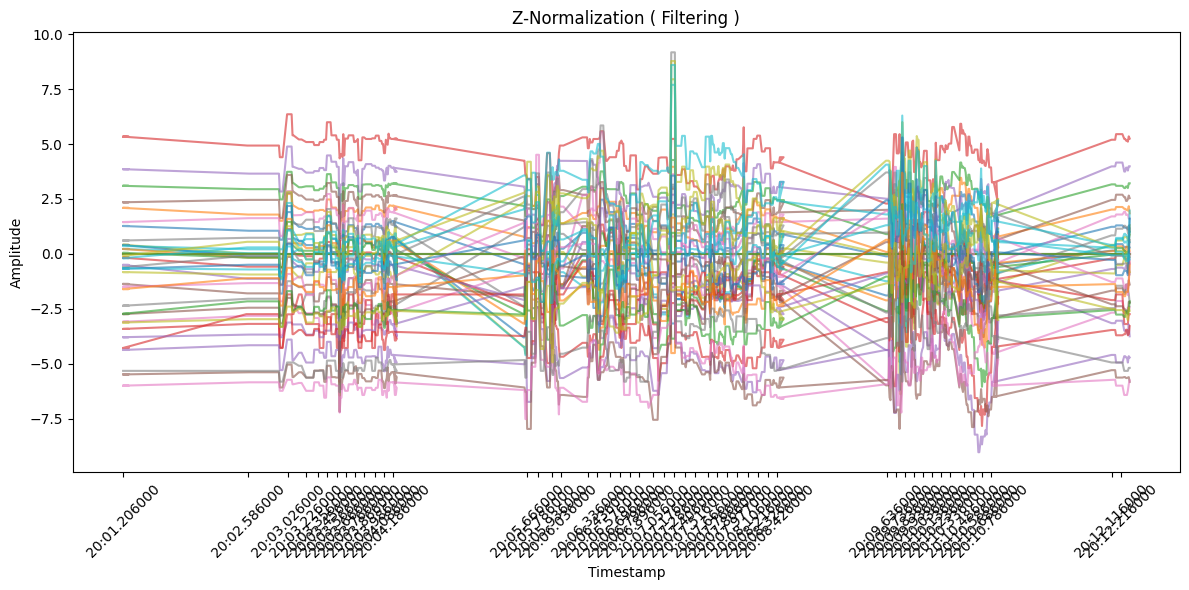

In [8]:
amp_norm_filtered = filter_normalization(amp_normalized)

plot_csi_amplitude(amp_normalized, ts_activity, title="Z-Normalization")
plot_csi_amplitude(amp_norm_filtered, ts_activity, title="Z-Normalization ( Filtering )")

#### 4th Processing : Hampel filtering (이상치 제거 )

In [9]:
def robust_hampel(col, window=5, n_sigma=3): # src/atif.py
    """Hampel filter로 이상치 제거"""
    median = medfilt(col, kernel_size=window)
    dev    = np.abs(col - median)
    mad    = np.median(dev)
    out    = dev > n_sigma * mad
    col[out] = median[out]
    return col

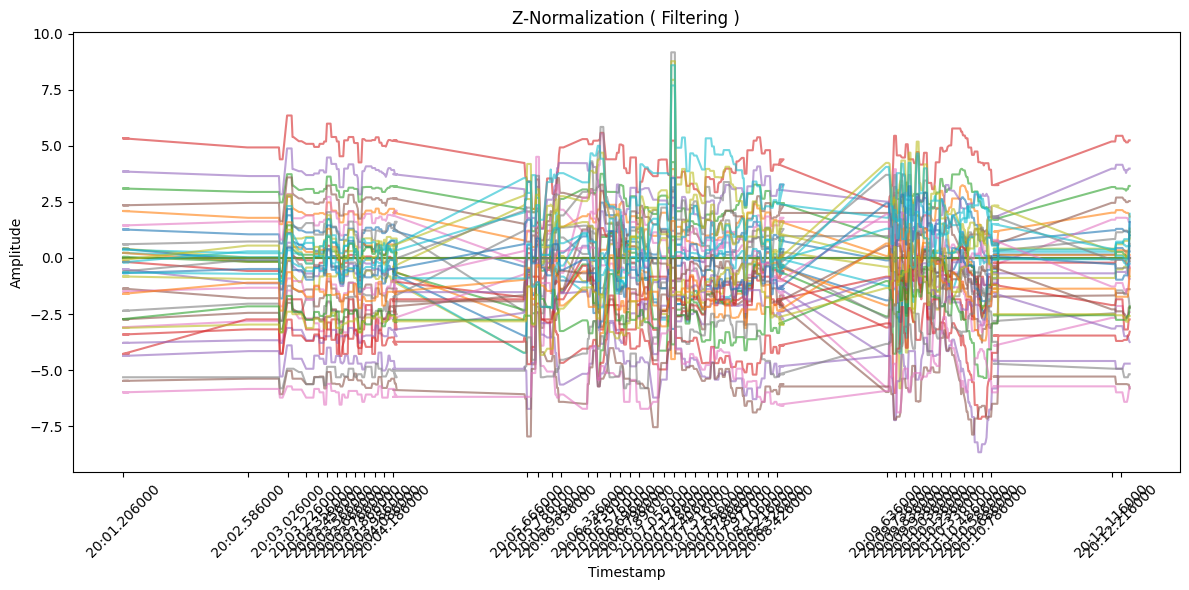

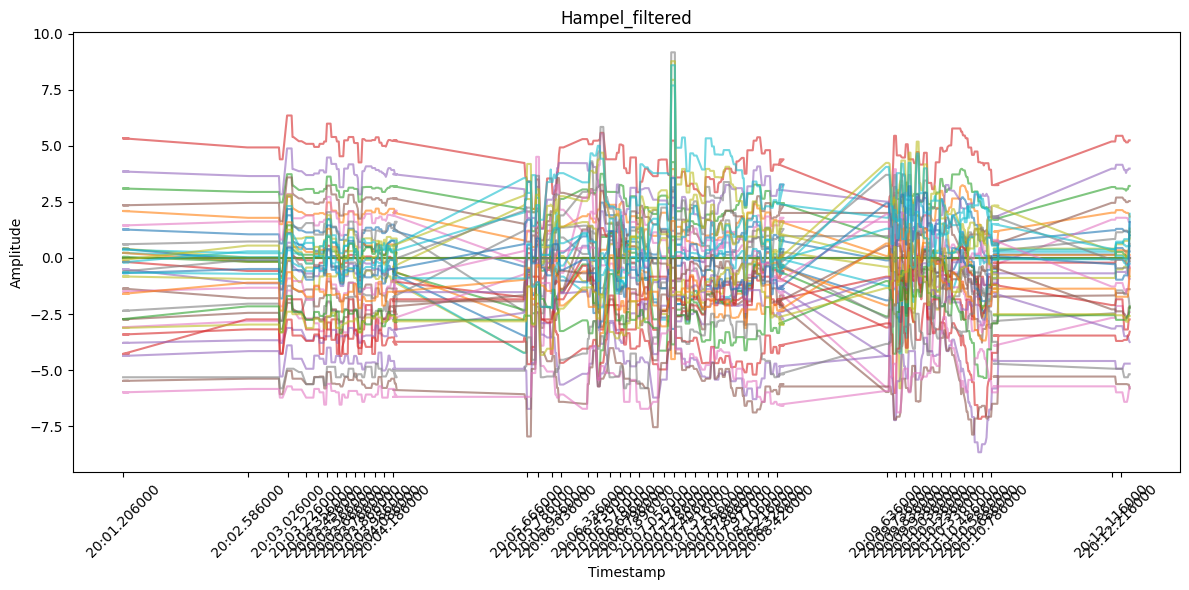

In [10]:
Hampel_filtered = np.apply_along_axis(robust_hampel, 0, amp_norm_filtered)

plot_csi_amplitude(amp_norm_filtered, ts_activity, title="Z-Normalization ( Filtering )")
plot_csi_amplitude(Hampel_filtered, ts_activity, title="Hampel_filtered")

#### 5th Processing : detrending -> 프레임별 평균 제거 & 서브캐리어 기준선 제거

In [11]:
def detrending_amp(amp, historical_window=100):
    """
    Desc:
        2단계 Detrending을 수행하는 함수
        - 1단계: 프레임별 평균 제거 (프레임 중심화)
        - 2단계: 서브캐리어 기준선 제거 (현재 평균 + 과거 평균의 평균)
    Parameters:
        amp : Hampel_filtered
        historical_window : 기준선 계산에 사용할 초기 프레임 수 (기본값: 100)
    Example:
        Hampel_filtered = np.apply_along_axis(robust_hampel, 0, amp_norm_filtered)
        detrended = detrending_amp(Hampel_filtered, historical_window=100)
    """
    # 1단계: 프레임별 평균 제거
    mean_per_frame = np.mean(amp, axis=1, keepdims=True)  
    detrended_packet = amp - mean_per_frame             

    # 2단계: 기준선 제거 (시간 평균 기준)
    mean_current = np.mean(amp, axis=0)                  
    mean_historical = np.mean(amp[:historical_window], axis=0)
    combined_mean = (mean_current + mean_historical) / 2    

    # 최종 detrending
    detrended = detrended_packet - combined_mean           

    return detrended


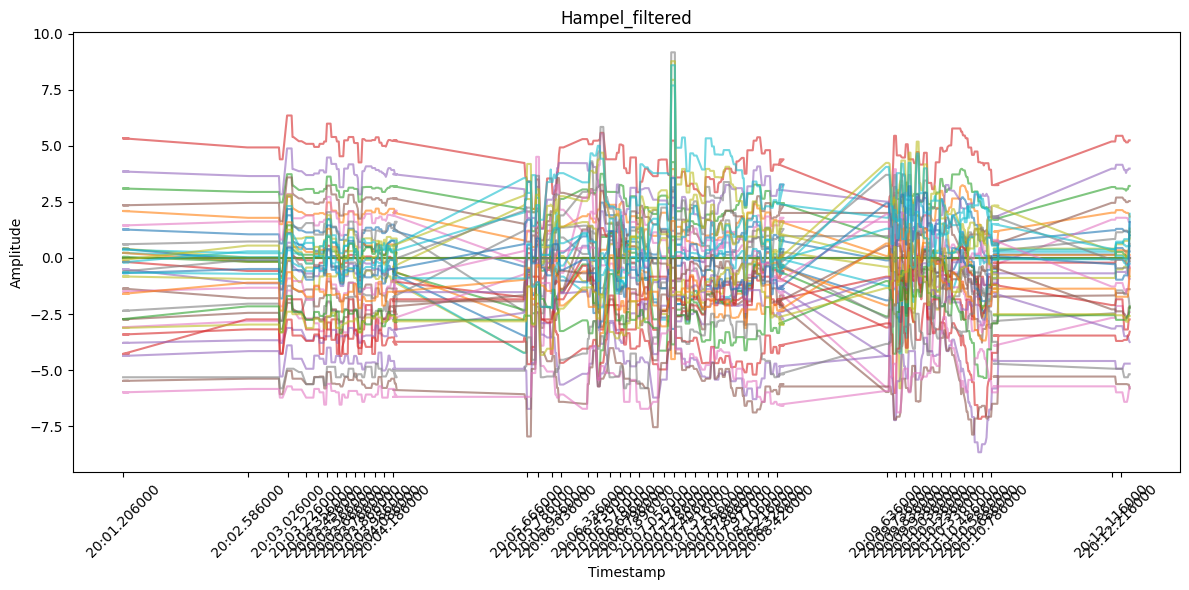

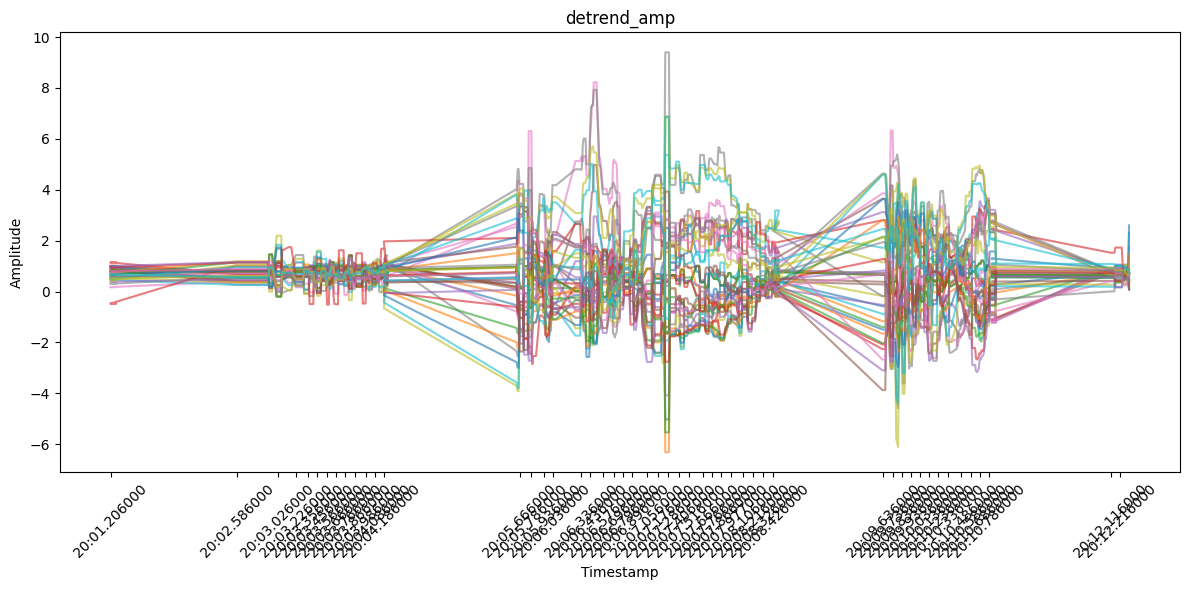

In [12]:
detrend_amp = detrending_amp(Hampel_filtered)

plot_csi_amplitude(Hampel_filtered, ts_activity, title="Hampel_filtered")
plot_csi_amplitude(detrend_amp, ts_activity, title="detrend_amp")

In [13]:
def extract_motion_features(detrended, WIN_SIZE=64):
    """
    Desc:
        CSI detrended 데이터로부터 움직임 특성을 추출하는 함수.
        프레임별 진폭 변화(std)를 계산하고, 미분 후 이동 평균 필터를 적용해 부드러운 움직임 특징을 생성.
        - 1단계: 프레임별 표준편차 계산
        - 2단계: 미분 + 절댓값 → 변화량 추출
        - 3단계: Overlap-save 이동 평균 필터 적용
    Parameters:
        detrended : Detrended amplitude 데이터 (frames x subcarriers)
        prev_samples : 이전 프레임 정보를 저장한 딕셔너리 버퍼 (topic → 배열)
        topic : 현재 처리 중인 topic 이름
        WIN_SIZE : 이동 평균 필터 크기 (기본값: 15)
    Example:
        detrended, _ = detrending_amp(Hampel_filtered)
        Feature, prev_samples = extract_motion_features(detrended, prev_samples, topic, WIN_SIZE=15)
    """
    # 1단계: 진폭 변화량 계산 (프레임별 표준편차)
    std_per_pkt = np.std(detrended, axis=1)

    # 2단계: 변화량 미분 후 절댓값 처리
    feature_derivative_abs = np.abs(np.diff(std_per_pkt))

    # 3단계: Overlap-save convolution 기반 이동 평균 필터
    prev_samples = np.zeros(WIN_SIZE)
    padded_signal = np.concatenate([prev_samples, feature_derivative_abs])
    window = np.ones(WIN_SIZE)
    convolved = np.convolve(padded_signal, window, mode='valid')

    # 4단계: 최신 변화량만 반환
    feature = convolved[-len(feature_derivative_abs):]

    return feature


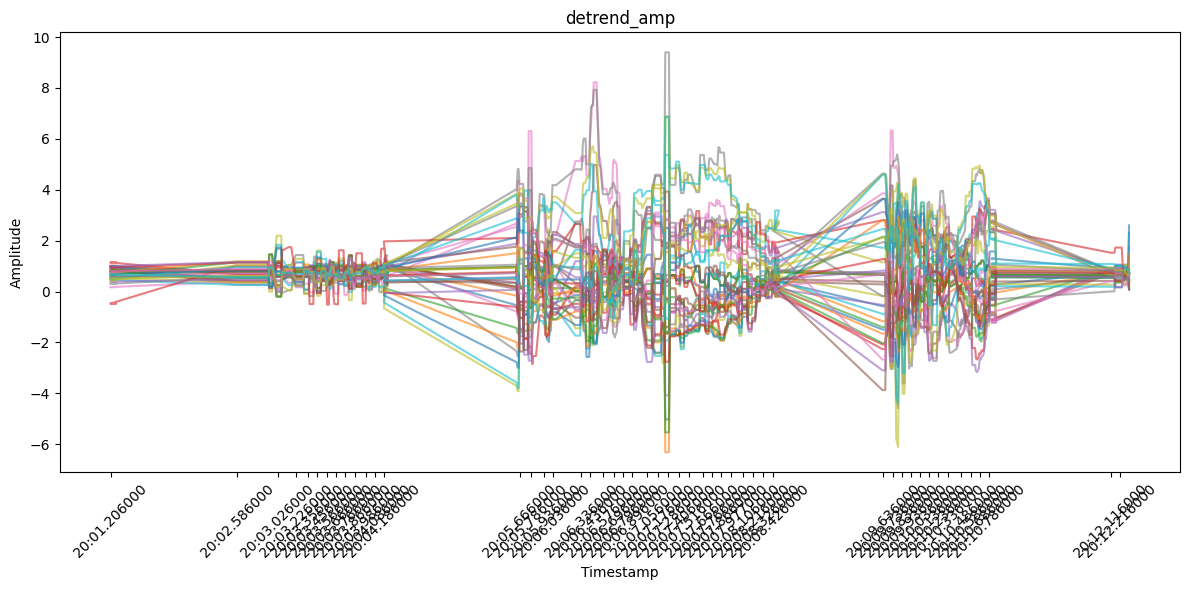

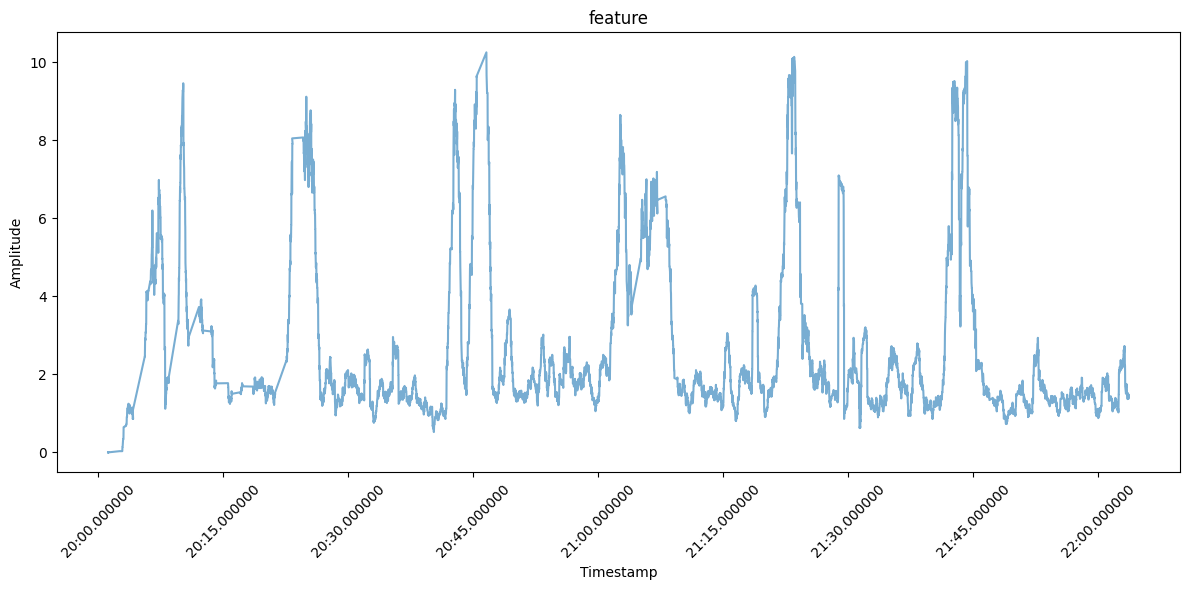

In [14]:
feature = extract_motion_features(detrend_amp)

plot_csi_amplitude(detrend_amp, ts_activity, title="detrend_amp")
plot_csi_amplitude(feature, ts_activity, title="feature")

In [15]:
def detect_activity_with_ewma(feature, threshold_factor=2.5):
    """
    Desc:
        CSI 배치 데이터에서 EWMA 방식으로 임계선을 계산하고, 움직임 감지를 수행하는 함수.
        실시간 상태 저장 없이도 배치 단위에서 바로 실행 가능.

    Parameters:
        feature : 입력된 변화량 시계열 (1D array-like)
        threshold_factor : 평균 대비 임계 배율 (기본값: 2.5)
    Example:
        ewma, Th, activity = detect_activity_with_ewma(feature)
    """
    avgSigVal = np.mean(feature)
    ewma = avgSigVal  # 상태 유지 없이 한 번에 계산
    threshold = threshold_factor * ewma
    activity_flag = (feature > threshold).astype(float)

    return activity_flag, threshold


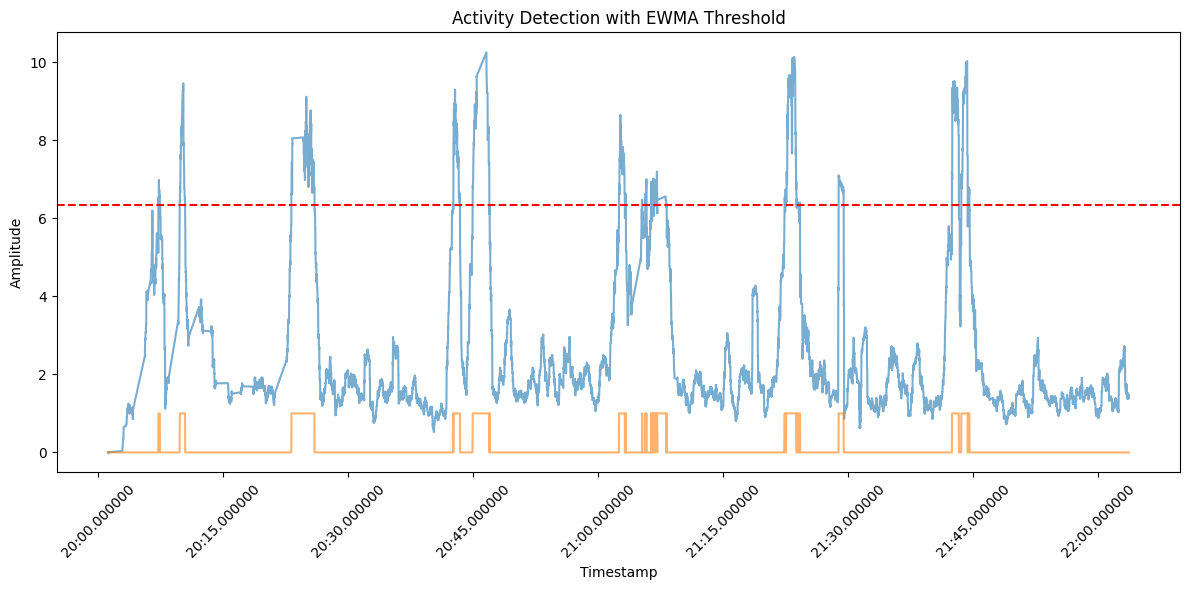

In [16]:
activity_flag, threshold = detect_activity_with_ewma(feature) 

plot_csi_amplitude(feature, ts_activity, title="Activity Detection with EWMA Threshold", amp2=activity_flag, amp3=threshold )